#ASL Image Classification

###Introduction
This work focuses on the automatic classification of American Sign Language (*ASL*) images with the help of CNN.\
The model must correctly recognize the **hand movements** in the images to facilitate communication for individuals with hearing difficulties.\
The **ASL Image Classification** has 27 classes wich 26 of them are signs for letters/numbers like "please", "hello", "9", "2" and the 27th one is the 'NULL' class for irrelevant gestures.

###What's the goal?
To create a Convolutional Neural Network (CNN) and train it to identify these sogns with high accuracy.

###Methods
- Python with **Keras/TensorFlow** for the model.
- **Label encoding** and **splitting data**.
- Class balance for  ***NULL*** class (it is underpressented and we want to make sure that the model doesn't ignore the class).
- **ImageDataGenerator** to avoid RAM overload.
- **early stopping** and **learning late scheduler**.

#1. Load Dataset.
I have uploaded my dataset on my personal Google Drive so i'm going to dive in and collect the paths of the dataset.

In [ ]:
import os
#loading dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

dataset = "/content/drive/MyDrive/archive"
print("Available files:", os.listdir(dataset))

Mounted at /content/drive
Available files: ['X.npy', 'Y.npy']


#2.  Load .npy files.
Here I'm loading the **'X.npy'** file (image data) and the **'Y.npy'** file (label data)

In [ ]:
import numpy as np

X = np.load(os.path.join(dataset, "X.npy"), mmap_mode='r')  # Memory-mapped
Y = np.load(os.path.join(dataset, "Y.npy"))
print(f"Original shape: X={X.shape}, Y={Y.shape}")

#to check what data type we have and if it is normalized
print(X.dtype)
print(np.min(X), np.max(X))

unique_labels = np.unique(Y)
print("Labels",unique_labels)

Original shape: X=(22801, 128, 128, 3), Y=(22801, 1)
float32
0.0 1.0
Labels ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'NULL' 'a' 'b' 'bye' 'c' 'd' 'e'
 'good' 'good morning' 'hello' 'little bit' 'no' 'pardon' 'please'
 'project' 'whats up' 'yes']


###Note!
There is a **NULL** class in our data and it may have empty data/false labels/noise. Instead of deleting this, we are going to use **class weights** later, in order to train the model in these cases.

#3. Visualize Random samples.

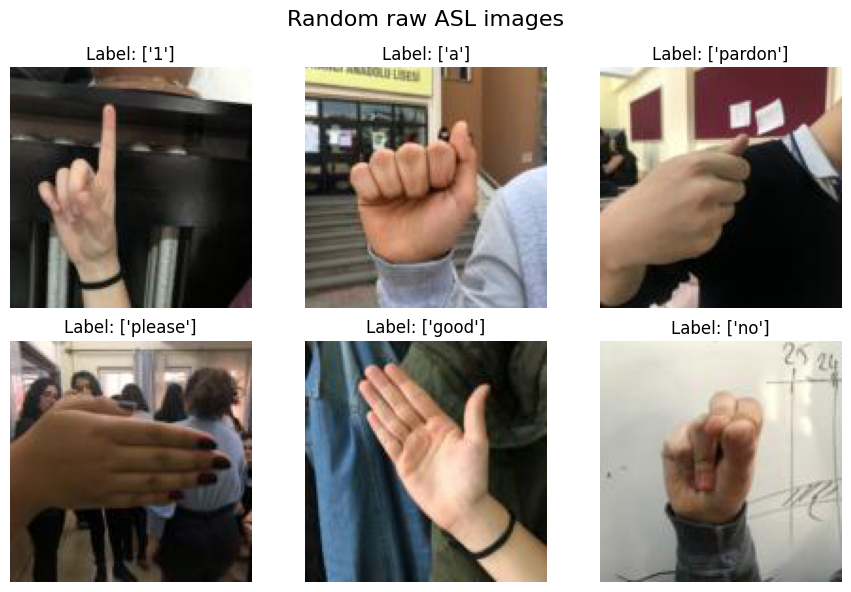

Number of images per class (before split):
0: 866 images
1: 865 images
2: 865 images
3: 865 images
4: 864 images
5: 865 images
6: 865 images
7: 865 images
8: 865 images
9: 865 images
NULL: 314 images
a: 863 images
b: 866 images
bye: 865 images
c: 865 images
d: 865 images
e: 863 images
good: 865 images
good morning: 865 images
hello: 865 images
little bit: 865 images
no: 865 images
pardon: 865 images
please: 865 images
project: 865 images
whats up: 865 images
yes: 865 images


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
for i in range(6):
    idx = np.random.randint(len(X))
    plt.subplot(2, 3, i + 1)
    plt.imshow(X[idx])
    plt.title(f"Label: {Y[idx]}")
    plt.axis('off')
plt.suptitle("Random raw ASL images", fontsize=16)
plt.tight_layout()
plt.show()

classes, counts = np.unique(Y, return_counts=True)

print("Number of images per class (before split):")
for cls, count in zip(classes, counts):
    print(f"{cls}: {count} images")

#4.  Encoding Labels
The next step is to encode our labels (ex. 'please' , 'little') into numeric class indeces -> important for categorial classification in keras.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
print("encoded labels", np.unique(Y_encoded)) #na dw thn telikh morfh tous

encoded labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#5. Splitting Data
Now im gonna split the data to train and test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.2, stratify=Y_encoded, random_state=42 #i have 80%train and 20%test
)

#6. Check Balance

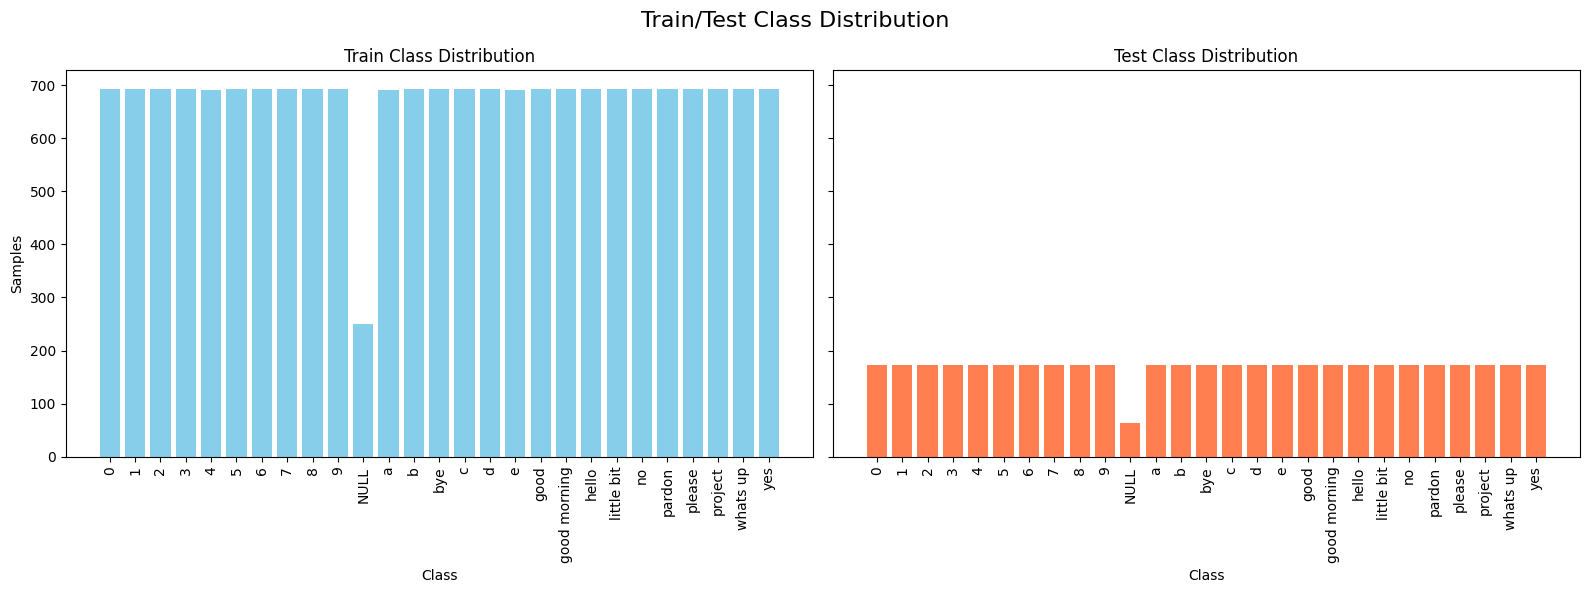

In [ ]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axes[0].bar(train_classes, train_counts, color='skyblue')
axes[0].set_title("Train Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Samples")
axes[0].set_xticks(train_classes)
axes[0].set_xticklabels([label_encoder.classes_[i] for i in train_classes], rotation=90)

axes[1].bar(test_classes, test_counts, color='coral')
axes[1].set_title("Test Class Distribution")
axes[1].set_xlabel("Class")
axes[1].set_xticks(test_classes)
axes[1].set_xticklabels([label_encoder.classes_[i] for i in test_classes], rotation=90)

plt.suptitle("Train/Test Class Distribution", fontsize=16)
plt.tight_layout()
plt.show()

all classes are very well balanced and each class has about the same number of images (~ 700 in train, ~ 170 in test).  
The only exception is the class `'NULL'`, which has fewer samples (~250 in train, ~60 in test).
We only need to be carefull on the `'NULL'` class. So instead of removing it, we chose to keep it and use **class weighting** during training.

#7. Weighting
To handle the imbalance, we assign a higher training wieght (2.0) in order to prevent the model from ignoring the `'NULL'` class.

In [ ]:
null_index = list(label_encoder.classes_).index('NULL')

class_weights_dict = {i: 1.0 for i in range(len(label_encoder.classes_))}
class_weights_dict[null_index] = 2.0 #posh varuthta tha tou dwsw  #dokimase to kai me 2.5 mprei na dwsei kaluterh apodosh

for i, weight in class_weights_dict.items():
    print(f"Class '{label_encoder.classes_[i]}': weight = {weight:.2f}") #what's the weight of each class

Class '0': weight = 1.00
Class '1': weight = 1.00
Class '2': weight = 1.00
Class '3': weight = 1.00
Class '4': weight = 1.00
Class '5': weight = 1.00
Class '6': weight = 1.00
Class '7': weight = 1.00
Class '8': weight = 1.00
Class '9': weight = 1.00
Class 'NULL': weight = 2.00
Class 'a': weight = 1.00
Class 'b': weight = 1.00
Class 'bye': weight = 1.00
Class 'c': weight = 1.00
Class 'd': weight = 1.00
Class 'e': weight = 1.00
Class 'good': weight = 1.00
Class 'good morning': weight = 1.00
Class 'hello': weight = 1.00
Class 'little bit': weight = 1.00
Class 'no': weight = 1.00
Class 'pardon': weight = 1.00
Class 'please': weight = 1.00
Class 'project': weight = 1.00
Class 'whats up': weight = 1.00
Class 'yes': weight = 1.00


#8. Visualize Random images after processing

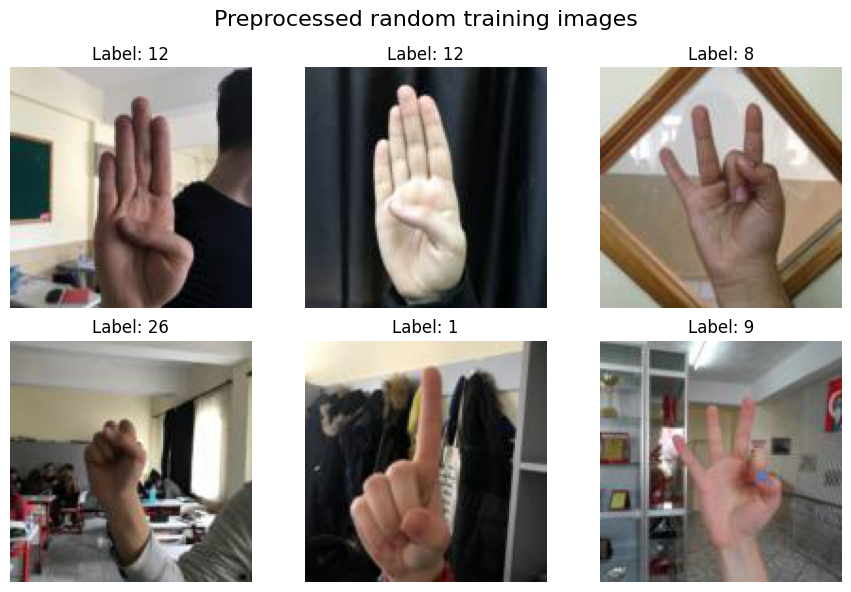

In [ ]:
plt.figure(figsize=(9, 6))
for i in range(6):
    idx = np.random.randint(len(X_train))
    label_name = y_train[idx]  # already string
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Label: {label_name}")
    plt.axis('off')
plt.suptitle("Preprocessed random training images", fontsize=16)
plt.tight_layout()
plt.show()


#9. Use of ImageDataGenerator

Just because our dataset is really big, we want to make it friendlier for the RAM, so that it does not use much space. WE will use `ImageDataGenerator` with `validation_split=0.2` in roder to load images in memory-efficient batches and automatically create training and validation splits.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(validation_split=0.2)
train_gen = datagen.flow(X_train, y_train, batch_size=16, subset='training', shuffle=True)
val_gen = datagen.flow(X_train, y_train, batch_size=16, subset='validation')

#10. Define CNN Model
WE used 'Dropout(0.3)' so the model will learn general patterns.\


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout

model = Sequential([
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=X.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3), #i had o.5 but changed it to 0.3 to be a little simplier (it holds more signal) maybe the accuracy will be higher
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,987 (1.56 MB)

 Trainable params: 408,091 (1.56 MB)

 Non-trainable params: 896 (3.50 KB)

#11. Callback for Early Stopping and LR Scheduling


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, monitor='val_loss', factor=0.5)


# 12. Train the Model

We train the model for up to 20 epochs using the data generators and callbacks. Class weights are passed to give more importance to the `'NULL'` class.

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


912/912 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.0807 - loss: 3.2575 - val_accuracy: 0.1554 - val_loss: 3.0761 - learning_rate: 0.0010
Epoch 2/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.3239 - loss: 2.2182 - val_accuracy: 0.3385 - val_loss: 2.5151 - learning_rate: 0.0010
Epoch 3/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5862 - loss: 1.2690 - val_accuracy: 0.6721 - val_loss: 1.0257 - learning_rate: 0.0010
Epoch 4/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.7318 - loss: 0.8272 - val_accuracy: 0.6820 - val_loss: 0.9706 - learning_rate: 0.0010
Epoch 5/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8073 - loss: 0.6008 - val_accuracy: 0.8161 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 6/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8556 - loss: 0.4445 - val_accuracy: 0.8350 - val_loss: 0.5154 - learning_rate: 0.0010
Epoch 7/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8880 - loss: 0.3438

#13. Training Performance
Matching curves indicate balanced generalization

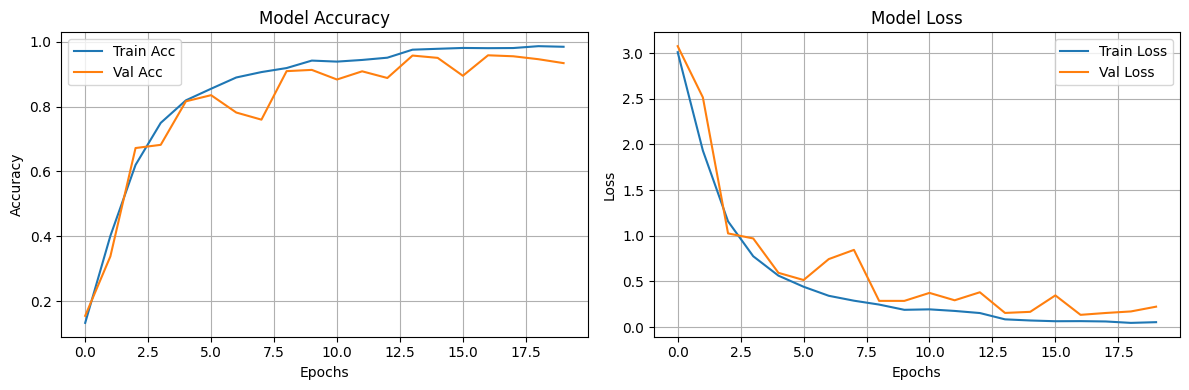

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

#14. Prediction on Test set and Visualize

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


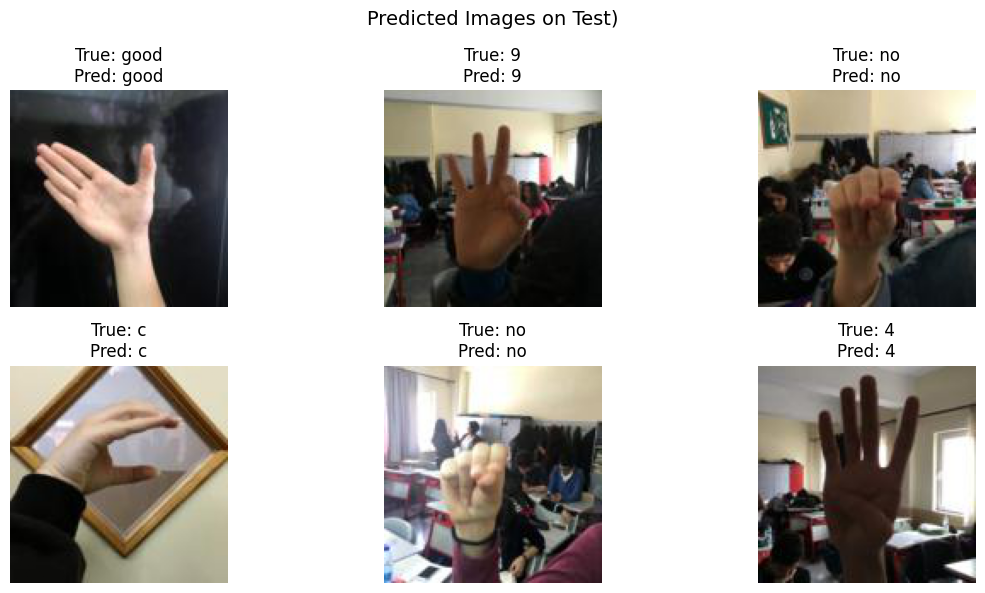

In [ ]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

plt.figure(figsize=(12, 6))
for i in range(6):
    idx = np.random.randint(len(X_test))
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]
    title = f"True: {label_encoder.classes_[true_label]}\nPred: {label_encoder.classes_[pred_label]}"
    color = 'black' if pred_label == true_label else 'red' #red -> wrong , black -> right
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(title, color=color)
    plt.axis('off')
plt.suptitle("Predicted Images on Test)", fontsize=14)
plt.tight_layout()
plt.show()


#15. Classification Report

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       173
           1       0.92      0.98      0.95       173
           2       0.98      0.93      0.96       173
           3       0.98      0.99      0.99       173
           4       0.94      0.92      0.93       173
           5       0.99      0.98      0.99       173
           6       0.99      0.88      0.93       173
           7       0.89      0.87      0.88       173
           8       0.83      0.97      0.89       173
           9       0.94      0.92      0.93       173
        NULL       0.98      0.90      0.94        63
           a       1.00      0.98      0.99       173
           b       0.98      0.99      0.99       173
         bye       1.00      0.97      0.99       173
           c       1.00      0.98      0.99       173
           d       1.00      0.97      0.99       173
           e       1.00      0.98      0.99       173
   

#15. Transfer Learning (Second solution)
I am using the MobileNetV2 pretrained CNN model for comparison purposes only. It is also a lightweight model.\
 Its base is ImageNet, so it knows some general images.\
Why did i use this pretrained model? **To see if it can outperform my custom CNN model.**\
Of course this model is trained on the same ASL dataset, using the same class weights, callbacks, and batch size.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze all pretrained layers

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Build final model
mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Compile
mobilenet_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#16. Train Model

In [ ]:
history_mobilenet = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict
)


Epoch 1/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.1491 - loss: 3.0679 - val_accuracy: 0.4997 - val_loss: 1.7288 - learning_rate: 1.0000e-04
Epoch 2/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4576 - loss: 1.7723 - val_accuracy: 0.6245 - val_loss: 1.2748 - learning_rate: 1.0000e-04
Epoch 3/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5698 - loss: 1.3641 - val_accuracy: 0.6774 - val_loss: 1.0760 - learning_rate: 1.0000e-04
Epoch 4/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6405 - loss: 1.1348 - val_accuracy: 0.7152 - val_loss: 0.9601 - learning_rate: 1.0000e-04
Epoch 5/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6850 - loss: 0.9794 - val_accuracy: 0.7297 - val_loss: 0.8913 - learning_rate: 1.0000e-04
Epoch 6/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7118 - loss: 0.8882 - val_accuracy: 0.7495 - val_loss: 0.8294 - learning_rate: 1.0000e-04
Epoch 7/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/ste

#17. Training Performance

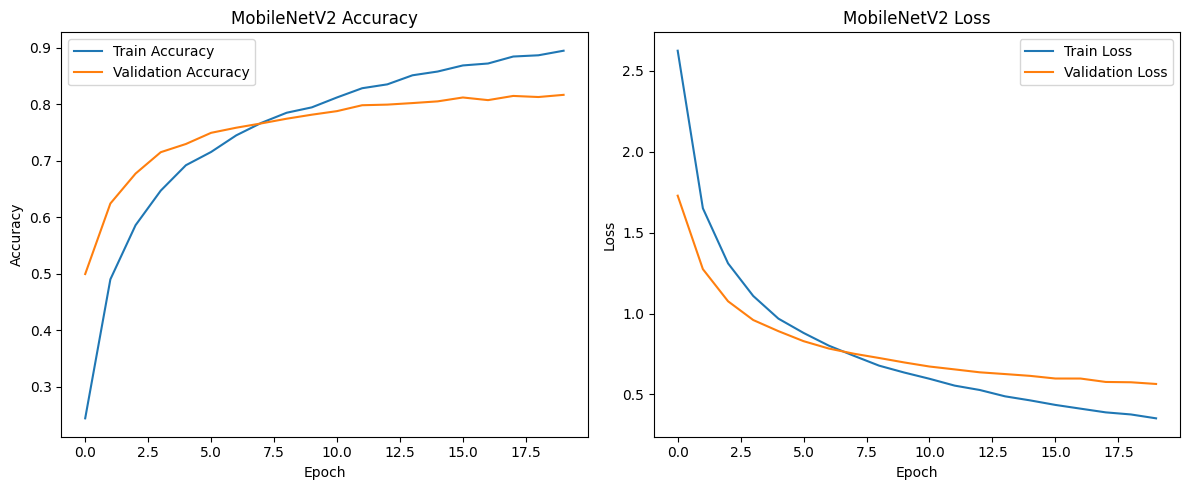

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#18. Predict on test and visualize

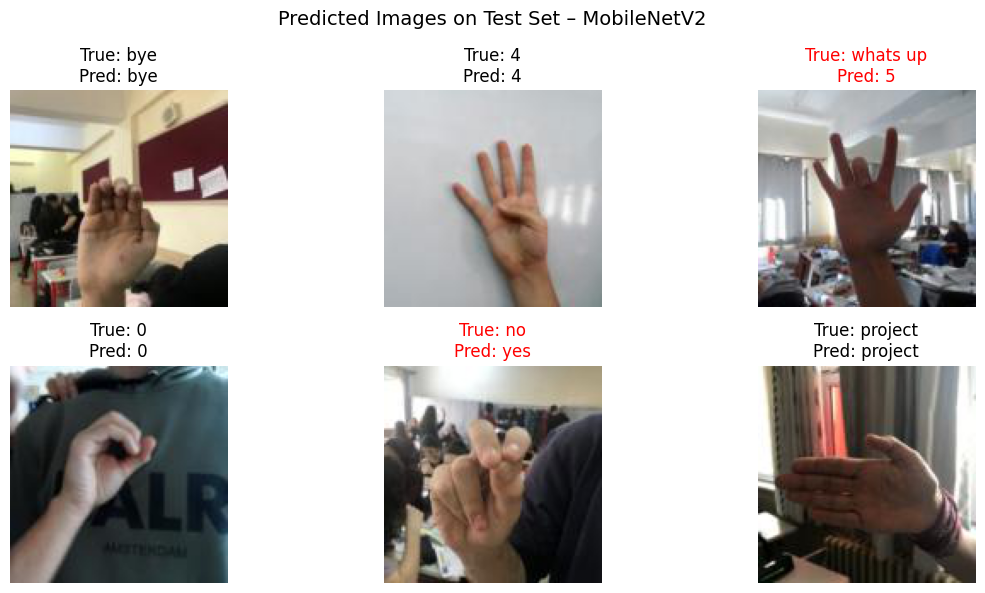

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
    idx = np.random.randint(len(X_test))
    true_label = y_test[idx]
    pred_label = y_pred_mobilenet_classes[idx]
    title = f"True: {label_encoder.classes_[true_label]}\nPred: {label_encoder.classes_[pred_label]}"
    color = 'black' if pred_label == true_label else 'red'  # red if wrong
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(title, color=color)
    plt.axis('off')
plt.suptitle("Predicted Images on Test Set – MobileNetV2", fontsize=14)
plt.tight_layout()
plt.show()

#19. Classification Report

In [ ]:
# Predict
y_pred_mobilenet = mobilenet_model.predict(X_test)
y_pred_mobilenet_classes = np.argmax(y_pred_mobilenet, axis=1)

#report
from sklearn.metrics import classification_report
print("MobileNetV2 Classification Report:")
print(classification_report(y_test, y_pred_mobilenet_classes, target_names=label_encoder.classes_))


143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step
MobileNetV2 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       173
           1       0.82      0.82      0.82       173
           2       0.71      0.71      0.71       173
           3       0.70      0.68      0.69       173
           4       0.76      0.72      0.74       173
           5       0.88      0.84      0.86       173
           6       0.60      0.58      0.59       173
           7       0.53      0.55      0.54       173
           8       0.62      0.58      0.60       173
           9       0.64      0.66      0.65       173
        NULL       1.00      0.90      0.95        63
           a       0.92      0.87      0.89       173
           b       0.85      0.95      0.90       173
         bye       0.91      0.90      0.90       173
           c       0.88      0.86      0.87       173
           d       0.94      0.92      0.93       173
   

#20. Conclusion
After experimenting a lot with the class weighting, dropout timing, batch sizing (adjustments) and learning rate scheduling the model achieved `97% accuracy` and a very balanced perfomance in all 27 classes!\
The `NULL` class was actually the problem but we resolved it with `class_weight = 2.0` that gave strong recall and precision (it was the best choice).\
There was no need for 'data augumentation' or 'transfer learning'. The dataset was pretty big and had great preformance on its own.\
Even though i tested the MobileNetV2 (pretrained CNN model) using transfer learning, it didn't perform very well like my custom CNN model. Specifically it only reached about `82% accuracy` — significantly lower than my own CNN.